In [1]:
import cv2
from PIL import Image
import random
import os, glob
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import os ,shutil

base_dir = './DLAI3_Phase3/DLAI3_Phase3/'
covid_dir = './DLAI3_Phase3/DLAI3_Phase3/COVID-19'
thor_dir = './DLAI3_Phase3/DLAI3_Phase3/THORAXDISEASE'
nf_dir = './DLAI3_Phase3/DLAI3_Phase3/NOFINDING'

print(os.listdir(base_dir))

['.ipynb_checkpoints', 'train', 'NOFINDING', 'THORAXDISEASE', 'test', 'COVID-19']


In [3]:
# train_dir = os.path.join(base_dir, 'train')
# os.mkdir(train_dir)
# test_dir = os.path.join(base_dir, 'test')
# os.mkdir(test_dir)
# print(train_dir)

./DLAI3_Phase3/DLAI3_Phase3/train


In [4]:
"""
# train

#nofinding
train_nf_dir = os.path.join(train_dir, 'NOFINDING')
os.mkdir(train_nf_dir)

#thoraxdisease
train_thor_dir = os.path.join(train_dir, 'THORAXDISEASE')
os.mkdir(train_thor_dir)

#covid 사진 디렉토리
train_covid_dir = os.path.join(train_dir, 'COVID-19')
os.mkdir(train_covid_dir)


# test

#nofinding
test_nf_dir = os.path.join(test_dir, 'NOFINDING')
os.mkdir(test_nf_dir)

#thoraxdisease
test_thor_dir = os.path.join(test_dir, 'THORAXDISEASE')
os.mkdir(test_thor_dir)
        
#covid 사진 디렉토리
test_covid_dir = os.path.join(test_dir, 'COVID-19')
os.mkdir(test_covid_dir)


covid_train_size = int(len(os.listdir(covid_dir)) * 0.8)

for img_cov in os.listdir(covid_dir)[:covid_train_size]:
    src = os.path.join(covid_dir, img_cov)
    dst = os.path.join(train_covid_dir, img_cov)
    shutil.copyfile(src, dst)

for img_cov in os.listdir(covid_dir)[covid_train_size:]:
    src = os.path.join(covid_dir, img_cov)
    dst = os.path.join(test_covid_dir, img_cov)
    shutil.copyfile(src, dst)

thor_train_size = int(len(os.listdir(thor_dir)) * 0.8)

for img_thor in os.listdir(thor_dir)[:thor_train_size]:
    src = os.path.join(thor_dir, img_thor)
    dst = os.path.join(train_thor_dir, img_thor)
    shutil.copyfile(src, dst)

for img_thor in os.listdir(thor_dir)[thor_train_size:]:
    src = os.path.join(thor_dir, img_thor)
    dst = os.path.join(test_thor_dir, img_thor)
    shutil.copyfile(src, dst)

nf_train_size = int(len(os.listdir(nf_dir)) * 0.8)

for img_nf in os.listdir(nf_dir)[:nf_train_size]:
    src = os.path.join(nf_dir, img_nf)
    dst = os.path.join(train_nf_dir, img_nf)
    shutil.copyfile(src, dst)

for img_nf in os.listdir(nf_dir)[nf_train_size:]:
    src = os.path.join(nf_dir, img_nf)
    dst = os.path.join(test_nf_dir, img_thor)
    shutil.copyfile(src, dst)
"""

In [3]:
import torch
import torch.nn as nn

from torchvision import transforms, datasets
import torch.optim as optim
import torch.nn.functional as F

from tqdm.autonotebook import tqdm

In [4]:
device = 'cuda'
batch_size = 64
num_workers = 4
lr = 1e-3
momentum = 0.9
weight_decay = 1e-5
# epoch = 20
n_steps = 10000

In [5]:
from torch.utils.data import DataLoader, RandomSampler

"""
Image Resize & array to tensor & 증강
train set에만 적용한다. 
test는 unseen 이라고 가정되기때문에 어떤 변화든 줄 수 없음.
"""
data_transforms = {
    'train': transforms.Compose([
    transforms.Resize((64, 64)), #image resize
    transforms.RandomHorizontalFlip(), # image Horizontal Flip 
    transforms.RandomChoice([
        transforms.ColorJitter(0.2, 0.2, 0.2, 0.2), # color transform
        transforms.RandomResizedCrop(64), 
        transforms.RandomAffine(
            degrees=5, translate=(0.5, 0.5),
            scale=(0.8, 1.0), shear=5) # random 하게 이미지 변형
    ]),
    transforms.ToTensor(), # tensor type으로 변경
    transforms.Normalize((0.4452, 0.4457, 0.4464), (0.2592, 0.2596, 0.2600)), # image normalize
]),
    'test': transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.4452, 0.4457, 0.4464), (0.2592, 0.2596, 0.2600))
    ])
}

# torch datasets 사용하여 image folder로부터 dataset 객체를 생성한다.
train_dataset = datasets.ImageFolder('./DLAI3_Phase3/DLAI3_Phase3/train/', 
                                     transform=data_transforms['train'])
test_dataset = datasets.ImageFolder('./DLAI3_Phase3/DLAI3_Phase3/test/', 
                                    transform=data_transforms['test'])

# dataset 에서 data를 어떻게 sampling 할지 결정함.

sampler = RandomSampler(train_dataset,
                        replacement=True,
                        num_samples=batch_size * n_steps)


# 실제 학습 시 dataset에서 batch 단위로 갖고오도록 하는 DataLoader 를 생성하여 
# 이전에 설정한 dataset, sampler를 인자로 넣어준다.
train_dataloader = DataLoader(train_dataset, batch_size=batch_size,
                              sampler=sampler, num_workers=num_workers, shuffle=False)

test_dataloader = DataLoader(test_dataset, batch_size=batch_size,
                             shuffle=False, num_workers=num_workers)


print(len(train_dataset))
print(len(test_dataset))

4404
822


In [6]:
train_dataset.classes

['COVID-19', 'NOFINDING', 'THORAXDISEASE']

Size of train set: 4404
Input shape: torch.Size([3, 64, 64])
Label: 0


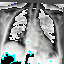

In [7]:
# Let's take a look at train dataset
# 임의의 index를 부여하여 dataset 내 image가 어떻게 변경이 되었는지 확인한다.
print(f"Size of train set: {len(train_dataset)}")
index = 0
x, y = train_dataset[index]
print(f"Input shape: {x.shape}")
print(f"Label: {y}")

transforms.functional.to_pil_image(x)

In [8]:
# Minimal MLP implementation
# DO NOT CHANGE Model name

class block(nn.Module):
    def __init__(self, dim_1, dim_2, stride=1):
        super(block, self).__init__()
        self.conv1 = nn.Conv2d(dim_1, dim_2, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(dim_2)
        self.conv2 = nn.Conv2d(dim_2, dim_2, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(dim_2)

        self.shortcut = nn.Sequential()
        if stride != 1 or dim_1 != dim_2:
            self.shortcut = nn.Sequential(
                nn.Conv2d(dim_1, dim_2, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(dim_2)
            )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)  

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Model(nn.Module):
    def __init__(self, num_classes=3):
        super(Model, self).__init__()
        self.in_dim = 64

        self.conv1 = nn.Conv2d(3, self.in_dim, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_dim)
        self.layer1 = self._make_layer(32*4, 2, stride=1)
        self.layer2 = self._make_layer(32*8, 2, stride=2)
        self.layer3 = self._make_layer(32*16, 2, stride=2)
        self.layer4 = self._make_layer(32*8, 2, stride=2)
        self.layer5 = self._make_layer(32*4, 2, stride=2)

        self.clf = nn.Sequential(nn.AdaptiveAvgPool2d((1, 1)), 
                                        nn.Flatten(), 
                                        nn.Linear(32*4, num_classes),
                                        nn.LogSoftmax(dim=-1))

    def _make_layer(self, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_dim, planes, stride))
            self.in_dim = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.clf(out)

        return out

In [9]:
import numpy as np
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt'):

        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.best_model = model
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
            self.best_score = score
            return self.best_model
        else:
            print(f'Validation loss decreased ({-self.best_score:.6f} --> {val_loss:.6f}).')
            self.best_score = score
            self.best_model = model
            # self.save_checkpoint(val_loss, model)
            self.counter = 0
            return self.best_model

    def save_checkpoint(self, val_loss, model):
        '''validation loss가 감소하면 모델을 저장한다.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).')
        # torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [13]:
model = Model()
early_stopping = EarlyStopping(patience=5, verbose=True)
best_model = None
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
model = model.to(device)

for step, (x, y) in enumerate(tqdm(train_dataloader), start=1):
    model.train()
    x, y = x.to(device), y.to(device)
    optimizer.zero_grad()
    pred = model(x)
    loss = criterion(pred, y)
    loss.backward()
    optimizer.step()
    scheduler.step()
    # Summary & Eval
    if step % 500 == 0:
        
        total, correct = 0, 0
        test_loss = 0
        model.eval()
        for x, y in tqdm(test_dataloader, leave=False):
            x, y = x.to(device), y.to(device)

            # Don't compute gradient during evaluation
            with torch.no_grad():
                pred = model(x)

            test_loss += criterion(pred, y) * x.shape[0]

            total += x.shape[0]
            correct += (pred.max(dim=1)[1] == y).sum()

        test_loss /= total
        accuracy = correct / total

        print(f"[Step {step}] train_loss: {loss.detach().squeeze():.2f}, test_loss: {test_loss:.2f}, test_accuracy: {accuracy:.4f}")

        best_model = early_stopping(test_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break
model = best_model

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

[Step 500] train_loss: 0.39, test_loss: 0.27, test_accuracy: 0.8905
Validation loss decreased (inf --> 0.272948).


  0%|          | 0/13 [00:00<?, ?it/s]

[Step 1000] train_loss: 0.20, test_loss: 0.05, test_accuracy: 0.9842
Validation loss decreased (0.272948 --> 0.051723).


  0%|          | 0/13 [00:00<?, ?it/s]

[Step 1500] train_loss: 0.19, test_loss: 0.05, test_accuracy: 0.9842
EarlyStopping counter: 1 out of 5


  0%|          | 0/13 [00:00<?, ?it/s]

[Step 2000] train_loss: 0.29, test_loss: 0.11, test_accuracy: 0.9611
EarlyStopping counter: 2 out of 5


  0%|          | 0/13 [00:00<?, ?it/s]

[Step 2500] train_loss: 0.22, test_loss: 0.09, test_accuracy: 0.9720
Validation loss decreased (0.108078 --> 0.088992).


  0%|          | 0/13 [00:00<?, ?it/s]

[Step 3000] train_loss: 0.25, test_loss: 0.04, test_accuracy: 0.9854
Validation loss decreased (0.088992 --> 0.044026).


  0%|          | 0/13 [00:00<?, ?it/s]

[Step 3500] train_loss: 0.08, test_loss: 0.13, test_accuracy: 0.9562
EarlyStopping counter: 1 out of 5


  0%|          | 0/13 [00:00<?, ?it/s]

[Step 4000] train_loss: 0.13, test_loss: 0.10, test_accuracy: 0.9635
Validation loss decreased (0.130680 --> 0.100335).


  0%|          | 0/13 [00:00<?, ?it/s]

[Step 4500] train_loss: 0.15, test_loss: 0.07, test_accuracy: 0.9745
Validation loss decreased (0.100335 --> 0.071089).


  0%|          | 0/13 [00:00<?, ?it/s]

[Step 5000] train_loss: 0.10, test_loss: 0.08, test_accuracy: 0.9672
EarlyStopping counter: 1 out of 5


  0%|          | 0/13 [00:00<?, ?it/s]

[Step 5500] train_loss: 0.24, test_loss: 0.11, test_accuracy: 0.9538
EarlyStopping counter: 2 out of 5


  0%|          | 0/13 [00:00<?, ?it/s]

[Step 6000] train_loss: 0.15, test_loss: 0.16, test_accuracy: 0.9392
EarlyStopping counter: 3 out of 5


  0%|          | 0/13 [00:00<?, ?it/s]

[Step 6500] train_loss: 0.28, test_loss: 0.09, test_accuracy: 0.9684
Validation loss decreased (0.157374 --> 0.086209).


  0%|          | 0/13 [00:00<?, ?it/s]

[Step 7000] train_loss: 0.18, test_loss: 0.03, test_accuracy: 0.9866
Validation loss decreased (0.086209 --> 0.033496).


  0%|          | 0/13 [00:00<?, ?it/s]

[Step 7500] train_loss: 0.14, test_loss: 0.03, test_accuracy: 0.9878
EarlyStopping counter: 1 out of 5


  0%|          | 0/13 [00:00<?, ?it/s]

[Step 8000] train_loss: 0.07, test_loss: 0.04, test_accuracy: 0.9842
EarlyStopping counter: 2 out of 5


  0%|          | 0/13 [00:00<?, ?it/s]

[Step 8500] train_loss: 0.04, test_loss: 0.08, test_accuracy: 0.9745
EarlyStopping counter: 3 out of 5


  0%|          | 0/13 [00:00<?, ?it/s]

[Step 9000] train_loss: 0.05, test_loss: 0.08, test_accuracy: 0.9745
EarlyStopping counter: 4 out of 5


  0%|          | 0/13 [00:00<?, ?it/s]

[Step 9500] train_loss: 0.03, test_loss: 0.07, test_accuracy: 0.9769
Validation loss decreased (0.082998 --> 0.074547).


  0%|          | 0/13 [00:00<?, ?it/s]

[Step 10000] train_loss: 0.09, test_loss: 0.07, test_accuracy: 0.9781
Validation loss decreased (0.074547 --> 0.065915).


In [14]:
torch.save(model.state_dict(), './resnet_torch_64x64_97_81.pt')

In [10]:
model = Model().to(device)

model.load_state_dict(torch.load('./resnet_torch_64x64_97_81.pt'))  # 모델 경로와 파일 이름에 맞게 수정


<All keys matched successfully>

In [11]:
train_dataset.class_to_idx

{'COVID-19': 0, 'NOFINDING': 1, 'THORAXDISEASE': 2}

In [12]:
import pandas as pd

class_map = {'NOFINDING':0, 'THORAXDISEASE':1, 'COVID-19':2}
my_class = {0:'COVID-19',1:'NOFINDING',2:'THORAXDISEASE'}

result_df = pd.DataFrame()

result_df

Empty DataFrame
Columns: []
Index: []

In [13]:
transform = data_transforms['test']
data_path = './VALIDATE/VALIDATE/'
data_list = os.listdir(data_path)
data_list.sort(key = lambda x : int(x.split('(')[-1].split(')')[0]))
pred_list = []
print(data_list)

for d in data_list:
    image = cv2.imread(data_path + d)
    image_from_array = Image.fromarray(image, 'RGB')
    img_torch = transform(image_from_array)
    X = img_torch.unsqueeze(0).to(device)

    with torch.no_grad():
        pred = model(X)
        pred_y = pred.max(dim=1)[1].detach().to('cpu').numpy()[0]
        pred_list.append(pred_y)


['VAL_SET3 (1).png', 'VAL_SET3 (2).png', 'VAL_SET3 (3).png', 'VAL_SET3 (4).png', 'VAL_SET3 (5).png', 'VAL_SET3 (6).png', 'VAL_SET3 (7).png', 'VAL_SET3 (8).png', 'VAL_SET3 (9).png', 'VAL_SET3 (10).png', 'VAL_SET3 (11).png', 'VAL_SET3 (12).png', 'VAL_SET3 (13).png', 'VAL_SET3 (14).png', 'VAL_SET3 (15).png', 'VAL_SET3 (16).png', 'VAL_SET3 (17).png', 'VAL_SET3 (18).png', 'VAL_SET3 (19).png', 'VAL_SET3 (20).png', 'VAL_SET3 (21).png', 'VAL_SET3 (22).png', 'VAL_SET3 (23).png', 'VAL_SET3 (24).png', 'VAL_SET3 (25).png', 'VAL_SET3 (26).png', 'VAL_SET3 (27).png', 'VAL_SET3 (28).png', 'VAL_SET3 (29).png', 'VAL_SET3 (30).png', 'VAL_SET3 (31).png', 'VAL_SET3 (32).png', 'VAL_SET3 (33).png', 'VAL_SET3 (34).png', 'VAL_SET3 (35).png', 'VAL_SET3 (36).png', 'VAL_SET3 (37).png', 'VAL_SET3 (38).png', 'VAL_SET3 (39).png', 'VAL_SET3 (40).png', 'VAL_SET3 (41).png', 'VAL_SET3 (42).png', 'VAL_SET3 (43).png', 'VAL_SET3 (44).png', 'VAL_SET3 (45).png', 'VAL_SET3 (46).png', 'VAL_SET3 (47).png', 'VAL_SET3 (48).png', 

In [14]:
result_df['ID'] = data_list
result_df['Code'] = pred_list

result_df['Code'] = result_df['Code'].map(my_class)
result_df['Code'] = result_df['Code'].map(class_map)
result_df

ID  Code
0        VAL_SET3 (1).png     1
1        VAL_SET3 (2).png     1
2        VAL_SET3 (3).png     1
3        VAL_SET3 (4).png     1
4        VAL_SET3 (5).png     1
...                   ...   ...
1125  VAL_SET3 (1126).png     1
1126  VAL_SET3 (1127).png     1
1127  VAL_SET3 (1128).png     1
1128  VAL_SET3 (1129).png     1
1129  VAL_SET3 (1130).png     1

[1130 rows x 2 columns]

In [28]:
result_df.to_csv('my_result.csv',index=False)